📈 En iyi kombinasyon (RSI, MACD ve SuperTrend ile):
RSI window = 5.0, RSI alım < 50.0, RSI satış > 80.0
MACD fast = 6.0, slow = 12.0, signal = 12.0
SuperTrend period = 10, multiplier = 8
Toplam Getiri: 19633.98


/var/folders/qz/2658g3zd0mncs35hg48gn9cw0000gn/T/ipykernel_35641/1902988420.py:172: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['date'])


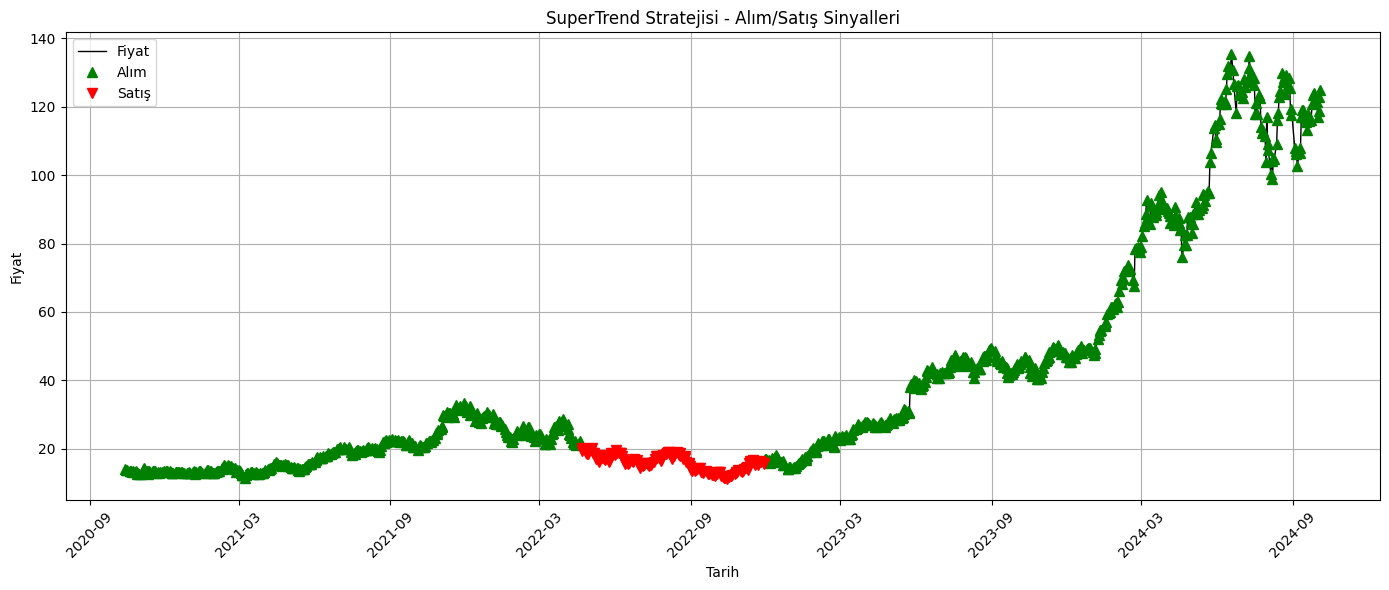

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Wilder RMA ve RSI hesaplama fonksiyonu
def wilder_rma(series, window):
    return series.ewm(alpha=1/window, adjust=False).mean()

def calc_rsi(data, window=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = wilder_rma(pd.Series(gain), window)
    avg_loss = wilder_rma(pd.Series(loss), window)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# MACD hesaplama fonksiyonu
def calc_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# RSI ve MACD sinyalleri ile backtest yapan fonksiyon (ilk optimizasyon)
def backtest_combined_cumulative(data, rsi_series, macd_series, signal_series,
                                  rsi_buy, rsi_sell, initial_capital=10000):
    capital = initial_capital
    position = False
    buy_price = 0

    for i in range(1, len(data)):
        close_price = data['close'].iloc[i]
        # Alım koşulu
        if not position and rsi_series[i] < rsi_buy and macd_series[i] > signal_series[i]:
            position = True
            buy_price = close_price
        # Satış koşulu
        elif position and rsi_series[i] > rsi_sell and macd_series[i] < signal_series[i]:
            position = False
            sell_price = close_price
            pct_change = (sell_price - buy_price) / buy_price
            capital *= (1 + pct_change)
    return capital - initial_capital

# SuperTrend hesaplama fonksiyonu
def compute_supertrend(df, period=10, multiplier=3):
    hl2 = (df['high'] + df['low']) / 2
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    upperband = hl2 + multiplier * atr
    lowerband = hl2 - multiplier * atr
    in_uptrend = [True]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > upperband.iloc[i - 1]:
            in_uptrend.append(True)
        elif df['close'].iloc[i] < lowerband.iloc[i - 1]:
            in_uptrend.append(False)
        else:
            in_uptrend.append(in_uptrend[i - 1])
            if in_uptrend[i] and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if not in_uptrend[i] and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]
    return pd.Series(in_uptrend, index=df.index)

# Üç göstergeyi (RSI, MACD, SuperTrend) kullanarak backtest yapan fonksiyon
def backtest_combined_strategy_supertrend(data, rsi, macd, signal, supertrend,
                                            rsi_buy, rsi_sell, initial_capital=10000):
    capital = initial_capital
    position = False
    buy_price = 0
    for i in range(1, len(data)):
        close = data['close'].iloc[i]
        # Alım: RSI ve MACD şartlarına ek olarak SuperTrend'in uptrend olması
        if not position and rsi[i] < rsi_buy and macd[i] > signal[i] and supertrend[i] == True:
            position = True
            buy_price = close
        # Satış: RSI, MACD veya SuperTrend tersine dönerse pozisyon kapat
        elif position and (close>buy_price * 1.1):
            position = False
            sell_price = close
            pct = (sell_price - buy_price) / buy_price
            capital *= (1 + pct)
    return capital - initial_capital

# VERİYİ OKUMA
data = pd.read_csv('./data_set/Nvidia.csv')
data = data.head(1000).reset_index(drop=True)

# RSI & MACD için parametre optimizasyonu (ilk arama)
results = []
for rsi_window in range(5, 31, 5):
    rsi = calc_rsi(data, rsi_window)
    for rsi_buy in range(10, 51, 10):
        for rsi_sell in range(60, 91, 10):
            if rsi_buy >= rsi_sell:
                continue
            for macd_fast in range(6, 19, 2):
                for macd_slow in range(macd_fast + 2, 41, 2):
                    for macd_signal in range(4, 21, 4):
                        macd, signal_line = calc_macd(data, macd_fast, macd_slow, macd_signal)
                        ret = backtest_combined_cumulative(data, rsi, macd, signal_line, rsi_buy, rsi_sell)
                        results.append({
                            'rsi_window': rsi_window,
                            'rsi_buy': rsi_buy,
                            'rsi_sell': rsi_sell,
                            'macd_fast': macd_fast,
                            'macd_slow': macd_slow,
                            'macd_signal': macd_signal,
                            'return': ret
                        })

# Elde edilen sonuçlardan en iyi 10 kombinasyonu seçelim
df_results = pd.DataFrame(results)
top20 = df_results.sort_values(by='return', ascending=False).head(20)

# Top 10 sonuç için SuperTrend parametrelerini optimize edelim
best_overall = {
    'rsi_window': None,
    'rsi_buy': None,
    'rsi_sell': None,
    'macd_fast': None,
    'macd_slow': None,
    'macd_signal': None,
    'supertrend_period': None,
    'supertrend_multiplier': None,
    'return': -np.inf
}

# SuperTrend parametre aralıkları
supertrend_period_range = range(10, 31, 5)  # 10, 15, 20, 25, 30
supertrend_multiplier_range = range(3, 11)    # 3,4,...,10

for idx, combo in top20.iterrows():
    # İlgili kombinasyona göre RSI ve MACD hesapla
    rsi = calc_rsi(data, combo['rsi_window'])
    macd, signal_line = calc_macd(data, combo['macd_fast'], combo['macd_slow'], combo['macd_signal'])
    
    for st_period in supertrend_period_range:
        for st_multiplier in supertrend_multiplier_range:
            supertrend = compute_supertrend(data, period=st_period, multiplier=st_multiplier)
            profit = backtest_combined_strategy_supertrend(data, rsi, macd, signal_line, supertrend, 
                                                             combo['rsi_buy'], combo['rsi_sell'])
            if profit > best_overall['return']:
                best_overall = {
                    'rsi_window': combo['rsi_window'],
                    'rsi_buy': combo['rsi_buy'],
                    'rsi_sell': combo['rsi_sell'],
                    'macd_fast': combo['macd_fast'],
                    'macd_slow': combo['macd_slow'],
                    'macd_signal': combo['macd_signal'],
                    'supertrend_period': st_period,
                    'supertrend_multiplier': st_multiplier,
                    'return': profit
                }

print("📈 En iyi kombinasyon (RSI, MACD ve SuperTrend ile):")
print(f"RSI window = {best_overall['rsi_window']}, RSI alım < {best_overall['rsi_buy']}, RSI satış > {best_overall['rsi_sell']}")
print(f"MACD fast = {best_overall['macd_fast']}, slow = {best_overall['macd_slow']}, signal = {best_overall['macd_signal']}")
print(f"SuperTrend period = {best_overall['supertrend_period']}, multiplier = {best_overall['supertrend_multiplier']}")
print(f"Toplam Getiri: {best_overall['return']:.2f}")

# Opsiyonel: En iyi SuperTrend sinyallerini görselleştirelim
def plot_supertrend_signals(data, supertrend_series):
    data['date'] = pd.to_datetime(data['date'])
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data['date'], data['close'], label='Fiyat', color='black', linewidth=1)
    uptrend = supertrend_series == True
    downtrend = supertrend_series == False
    ax.plot(data['date'][uptrend], data['close'][uptrend], '^', color='green', label='Alım', markersize=7)
    ax.plot(data['date'][downtrend], data['close'][downtrend], 'v', color='red', label='Satış', markersize=7)
    ax.set_title("SuperTrend Stratejisi - Alım/Satış Sinyalleri")
    ax.set_xlabel("Tarih")
    ax.set_ylabel("Fiyat")
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# En iyi kombinasyona ait RSI, MACD ve SuperTrend değerlerini tekrar hesaplayıp grafiğe dökelim
best_rsi = calc_rsi(data, best_overall['rsi_window'])
best_macd, best_signal = calc_macd(data, best_overall['macd_fast'], best_overall['macd_slow'], best_overall['macd_signal'])
best_supertrend = compute_supertrend(data, period=best_overall['supertrend_period'], multiplier=best_overall['supertrend_multiplier'])
plot_supertrend_signals(data.reset_index(), best_supertrend)